In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline

import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
# What version of Python do you have?
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Tensor Flow Version: 2.1.1-dlenv_tfe
Keras Version: 2.3.0-tf

Python 3.7.6 | packaged by conda-forge | (default, Jun  1 2020, 18:57:50) 
[GCC 7.5.0]
Pandas 1.0.5
Scikit-Learn 0.23.1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available


In [7]:
# https://github.com/codebasics/py/blob/master/ML/FeatureEngineering/1_outliers/1_outliers_percentile.ipynb

In [3]:
# from google.cloud import bigquery
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import glob


# def make_query_utility(fuse_project_id, fuse_dataset_id, fuse_bucket, fuse_bq_key):
    
#     BQ_CLIENT = bigquery.Client.from_service_account_json(fuse_bq_key)


#     def query(query_string):
#         formatted_string = query_string.format(project=fuse_project_id, dataset=fuse_dataset_id)
#         query_job = BQ_CLIENT.query(formatted_string)
#         dataframe = query_job.result().to_dataframe().astype(float, errors='ignore')
#         return dataframe

#     return query

# query = make_query_utility('kohls-merch-in-lle', 'FUSE_STG01', 'kohls-merch-fuse-dataload', 'bigquery_key.json')


# data = query("""
#   select *
#       from `kohls-merch-in-lle`.FUSE_LOCAL_TEST.DEMAND_TRAINING_15_543_WALKIN
#         where beginning_of_week between "2018-06-01" and  '2020-06-28'
        
       

# """)

In [4]:
# data.total_sales = data.total_sales.astype(int)
# data.node = data.node.astype(int)
# data.is_holiday = data.is_holiday.astype(int)
# data.cl_nbr = data.cl_nbr.astype(int)
# data.sub_cl_nbr = data.sub_cl_nbr.astype(int)

In [5]:
data = pd.read_csv('data_train_prepared_level1.csv')
data.shape

(15713004, 10)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15713004 entries, 0 to 15713003
Data columns (total 10 columns):
 #   Column                Dtype  
---  ------                -----  
 0   total_sales           int64  
 1   total_revenue         float64
 2   advertised_purchases  float64
 3   is_holiday            int64  
 4   node                  int64  
 5   dept_nbr              float64
 6   cl_nbr                int64  
 7   sub_cl_nbr            int64  
 8   subclass_id           object 
 9   beginning_of_week     object 
dtypes: float64(3), int64(5), object(2)
memory usage: 1.2+ GB


In [11]:
print("Min data from dataset:" , data['beginning_of_week'].min())
print("MAX data from dataset:" , data['beginning_of_week'].max())

Min data from dataset: 2018-06-03
MAX data from dataset: 2020-06-28


In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.xlim(min(data['total_sales']), max(data['total_sales']))
sns.boxenplot(data['total_sales'])

In [14]:
import pandas as pd
from scipy import stats
data['z_score']=stats.zscore(data['total_sales'])
# data.hist()
data=data.loc[data['z_score'].abs()<=3]
data.shape 

(15476803, 11)

In [15]:
data['z_score_total_revenue']=stats.zscore(data['total_revenue'])
data=data.loc[data['z_score_total_revenue'].abs()<=3]
data.shape 

(15095242, 12)

In [16]:
data['z_score_total_sales']=stats.zscore(data['total_sales'])
data=data.loc[data['z_score_total_sales'].abs()<=3]
data.shape

(14684773, 13)

In [17]:
del data['z_score']

In [18]:
data.total_sales.value_counts().to_csv('data_train_prepared_level2.csv', index = False)

Text(0.5, 1.0, 'Total Sales Distribution')

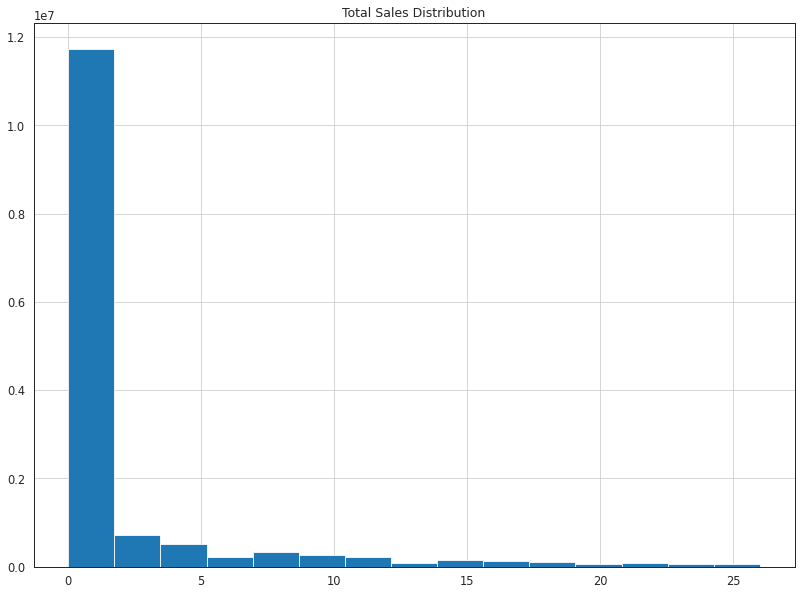

In [19]:
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
data['total_sales'].hist(bins=15)
plt.title('Total Sales Distribution')

In [20]:
data.shape

(14684773, 12)

# Preprocssing Data

In [21]:
def is_holiday_func(col):
        data[col] = data[[col]].applymap(lambda x: 1 if x > 1 else 0)
        data[col].value_counts()

        
is_holiday_func('is_holiday')

In [22]:
import datetime
import pandas as pd
import numpy as np
data['beginning_of_week'] = pd.to_datetime( data['beginning_of_week'] , format='%Y-%m-%d')
def extract_date(col):
        # make the new columns using string indexing
        data['year'] = data[col].dt.year
        data['month'] = data[col].dt.month
        data['day'] = data[col].dt.day
        data['quarter']=pd.to_datetime(data[col]).dt.quarter
        data['smester']=np.where(data.quarter.isin([1,2]), 1 , 2)
        data['day_of_year']=pd.to_datetime(data[col]).dt.dayofyear
        data['week_of_year']=pd.to_datetime(data[col]).dt.weekofyear
        data['day_in_Month']=pd.to_datetime(data[col]).dt.days_in_month
        
extract_date('beginning_of_week')

In [23]:
from sklearn import preprocessing 
def encoding(col):
    label_encod = preprocessing.LabelEncoder()
    data[col] = label_encod.fit_transform(data[col])
    return data[col].value_counts()

# encoding('channel')
encoding('day_of_year')
encoding('year')

1    6971316
0    4113311
2    3600146
Name: year, dtype: int64

In [24]:
data['subclass_id'] = data['subclass_id'].str.replace(r'-', '').astype(int)
data['subclass_id'].head()


0    151010
1    151010
2    151010
3    151010
4    151010
Name: subclass_id, dtype: int64

In [25]:
data.to_csv('data_train_prepared_level3.csv' , index=False)

In [26]:
data = pd.read_csv('data_train_prepared_level3.csv')

In [27]:
data.shape

(14684773, 20)

In [28]:
print(data.columns)

Index(['total_sales', 'total_revenue', 'advertised_purchases', 'is_holiday',
       'node', 'dept_nbr', 'cl_nbr', 'sub_cl_nbr', 'subclass_id',
       'beginning_of_week', 'z_score_total_revenue', 'z_score_total_sales',
       'year', 'month', 'day', 'quarter', 'smester', 'day_of_year',
       'week_of_year', 'day_in_Month'],
      dtype='object')


In [29]:
lag_list = [1, 2 , 3]


for lag in lag_list:
    ft_name = ('advertise_shifted%s' % lag)
    data[ft_name] = data['advertised_purchases'].shift(lag)
    data[ft_name].fillna(0, inplace=True)
    ft_name = ('total_revenue_shifted%s' % lag)
    data[ft_name] = data['total_revenue'].shift(lag)
    data[ft_name].fillna(0, inplace=True)



In [30]:
data.total_revenue_shifted1.max() , data.total_revenue_shifted1.min()


(246.55000000000007, -197.03)

In [31]:
# Min value
f_min = lambda x: x.rolling(window=3, min_periods=1).min()
# Max value
f_max = lambda x: x.rolling(window=5, min_periods=1).max()
# Mean value
f_mean = lambda x: x.rolling(window=7, min_periods=1).mean()
# Standard deviation
f_std = lambda x: x.rolling(window=9, min_periods=1).std()

function_list = [f_min, f_max, f_mean]
function_name = ['min', 'max', 'mean']

for i in range(len(function_list)):
    data[('advertised_purchases_rolling_%s' % function_name[i])] = data.sort_values('beginning_of_week').groupby([ 'total_revenue'])['advertised_purchases'].apply(function_list[i])
    


In [32]:
# Min value
f_min = lambda x: x.rolling(window=3, min_periods=1).min()
# Max value
f_max = lambda x: x.rolling(window=5, min_periods=1).max()
# Mean value
f_mean = lambda x: x.rolling(window=7, min_periods=1).mean()
# Standard deviation
f_std = lambda x: x.rolling(window=9, min_periods=1).std()

function_list = [f_min, f_max, f_mean, f_std]
function_name = ['min', 'max', 'mean', 'std']

for i in range(len(function_list)):
    data[('total_revenue_rolling_%s' % function_name[i])] = data.sort_values('beginning_of_week').groupby([ 'advertised_purchases'])['total_revenue'].apply(function_list[i])
    data[('total_revenue_rolling_%s' % function_name[i])] .fillna(0 , inplace=True)

"Done"    

'Done'

In [33]:
data['expand_total_revenue_mean'] = data['total_revenue'].expanding(3).mean()
data['expand_total_revenue_mean'] .fillna(0, inplace=True)

data['expand_total_revenue_sum'] = data['total_revenue'].expanding(3).sum()
data['expand_total_revenue_sum'].fillna(0, inplace=True)

data['expand_advertised_purchases_mean'] = data['advertised_purchases'].expanding(3).mean()
data['expand_advertised_purchases_mean'].fillna(0, inplace=True)

data['expand_advertised_purchases_sum'] = data['advertised_purchases'].expanding(3).sum()
data['expand_advertised_purchases_sum'].fillna(0, inplace=True)


data['expand_node__sum'] =  data['node'].expanding(3).sum()
data['expand_node__sum'].fillna(0, inplace=True)
    
data['expand_node__mean'] =  data['node'].expanding(3).mean()
data['expand_node__mean'].fillna(0, inplace=True)

In [34]:
lag_list = [1, 2]


for lag in lag_list:
    ft_name = ('is_holiday_shifted%s' % lag)
    data[ft_name] = data['is_holiday'].shift(lag)
    data[ft_name].fillna(0, inplace=True)
    ft_name = ('node_shifted%s' % lag)
    data[ft_name] = data['node'].shift(lag)
    data[ft_name].fillna(0, inplace=True)


In [35]:
# Min value
f_min = lambda x: x.rolling(window=3, min_periods=1).min()
# Max value
f_max = lambda x: x.rolling(window=5, min_periods=1).max()
# Mean value
f_mean = lambda x: x.rolling(window=7, min_periods=1).mean()
# Standard deviation
f_std = lambda x: x.rolling(window=9, min_periods=1).std()

function_list = [f_min, f_max, f_mean]
function_name = ['min', 'max', 'mean']

for i in range(len(function_list)):
    data[('node_new_%s' % function_name[i])] = data.sort_values('beginning_of_week').groupby([ 'sub_cl_nbr'])['node'].apply(function_list[i])
    


data['expand_node__sum'] =  data['node'].expanding(3).sum()
data['expand_node__sum'].fillna(0, inplace=True)
    
data['expand_node__mean'] =  data['node'].expanding(3).mean()
data['expand_node__mean'].fillna(0, inplace=True)


In [36]:
from sklearn.preprocessing import MinMaxScaler
def MIN_MAX_SCALE(col):
    X = data[[col]].values # Modify to Numpy
    min_max_sc = preprocessing.MinMaxScaler()
    X_Scale = min_max_sc.fit_transform(X)
    data[col] = pd.DataFrame(X_Scale) # add to pandas DB


In [37]:
list_of_max_min = [ 'total_revenue', 'advertised_purchases', 'node', 
                    'advertise_shifted1', 'advertise_shifted2', 'advertise_shifted3', 'total_revenue_shifted1', 
                   'total_revenue_shifted2', 'total_revenue_shifted3', 'advertised_purchases_rolling_min', 
                   'advertised_purchases_rolling_max',
                   'advertised_purchases_rolling_mean', 'total_revenue_rolling_min', 'total_revenue_rolling_max',
                   'total_revenue_rolling_mean','total_revenue_rolling_std',
                    'expand_total_revenue_mean', 'expand_total_revenue_sum', 'expand_advertised_purchases_mean', 
                   'expand_advertised_purchases_sum',
                   'node_shifted1', 'node_shifted2', 'node_new_min', 'node_new_max', 'node_new_mean', 
                   'expand_node__sum', 'expand_node__mean']

for i in list_of_max_min:
    MIN_MAX_SCALE(i)



# print(len(list(data)))

In [38]:
print(data.columns )

Index(['total_sales', 'total_revenue', 'advertised_purchases', 'is_holiday',
       'node', 'dept_nbr', 'cl_nbr', 'sub_cl_nbr', 'subclass_id',
       'beginning_of_week', 'z_score_total_revenue', 'z_score_total_sales',
       'year', 'month', 'day', 'quarter', 'smester', 'day_of_year',
       'week_of_year', 'day_in_Month', 'advertise_shifted1',
       'total_revenue_shifted1', 'advertise_shifted2',
       'total_revenue_shifted2', 'advertise_shifted3',
       'total_revenue_shifted3', 'advertised_purchases_rolling_min',
       'advertised_purchases_rolling_max', 'advertised_purchases_rolling_mean',
       'total_revenue_rolling_min', 'total_revenue_rolling_max',
       'total_revenue_rolling_mean', 'total_revenue_rolling_std',
       'expand_total_revenue_mean', 'expand_total_revenue_sum',
       'expand_advertised_purchases_mean', 'expand_advertised_purchases_sum',
       'expand_node__sum', 'expand_node__mean', 'is_holiday_shifted1',
       'node_shifted1', 'is_holiday_shifted2', 'n

In [39]:
col = ['total_revenue', 'advertised_purchases', 'is_holiday',
       'node', 'beginning_of_week', 'z_score_total_revenue', 'year', 'month', 'day',
       'quarter', 'smester', 'day_of_year', 'week_of_year', 'day_in_Month',
       'advertise_shifted1', 'total_revenue_shifted1', 'advertise_shifted2',
       'total_revenue_shifted2', 'advertise_shifted3',
       'total_revenue_shifted3', 'advertised_purchases_rolling_min',
       'advertised_purchases_rolling_max', 'advertised_purchases_rolling_mean',
       'z_score_total_sales', 'total_revenue_rolling_min',
       'total_revenue_rolling_max', 'total_revenue_rolling_mean',
       'total_revenue_rolling_std', 'expand_total_revenue_mean',
       'expand_total_revenue_sum', 'expand_advertised_purchases_mean',
       'expand_advertised_purchases_sum', 'is_holiday_shifted1',
       'node_shifted1', 'is_holiday_shifted2', 'node_shifted2', 'node_new_min',
       'node_new_max', 'node_new_mean', 'expand_node__sum',
       'expand_node__mean' , 'total_sales']

data = data.reindex(columns=col)


In [40]:
data.shape # 15476803

(14684773, 42)

In [41]:
data.head().T

0           1           2  \
total_revenue                          0.4442      0.4442      0.4442   
advertised_purchases                   0.0000      0.0000      0.0000   
is_holiday                                  0           0           0   
node                                   0.1731      0.0772      0.1695   
beginning_of_week                  2020-03-08  2019-09-08  2019-03-10   
z_score_total_revenue                 -0.3349     -0.3349     -0.3349   
year                                        2           1           1   
month                                       3           9           3   
day                                         8           8          10   
quarter                                     1           3           1   
smester                                     1           2           1   
day_of_year                                18          75          19   
week_of_year                               10          36          10   
day_in_Month                               31          30          31   
advertise_shifted1                     0.0000      0.0000      0.0000   
total_revenue_shifted1                 0.4442      0.4442      0.4442   
advertise_shifted2                     0.0000      0.0000      0.0000   
total_revenue_shifted2                 0.4442      0.4442      0.4442   
advertise_shifted3                     0.0000      0.0000      0.0000   
total_revenue_shifted3                 0.4442      0.4442      0.4442   
advertised_purchases_rolling_min       0.0000      0.0000      0.0000   
advertised_purchases_rolling_max       0.0000      0.0000      0.0000   
advertised_purchases_rolling_mean      0.0000      0.0000      0.0000   
z_score_total_sales                   -0.3588     -0.3588     -0.3588   
total_revenue_rolling_min              0.4479      0.4479      0.4479   
total_revenue_rolling_max              0.3620      0.3620      0.3620   
total_revenue_rolling_mean             0.3738      0.3738      0.3738   
total_revenue_rolling_std              0.0000      0.0000      0.0000   
expand_total_revenue_mean              0.0340      0.0340      0.0340   
expand_total_revenue_sum               0.0000      0.0000      0.0000   
expand_advertised_purchases_mean       0.0000      0.0000      0.0000   
expand_advertised_purchases_sum        0.0000      0.0000      0.0000   
is_holiday_shifted1                    0.0000      0.0000      0.0000   
node_shifted1                          0.0000      0.1740      0.0782   
is_holiday_shifted2                    0.0000      0.0000      0.0000   
node_shifted2                          0.0000      0.0000      0.1740   
node_new_min                           0.1772      0.1529      0.0768   
node_new_max                           0.1656      0.2082      0.1967   
node_new_mean                          0.2561      0.2028      0.2420   
expand_node__sum                       0.0000      0.0000      0.0000   
expand_node__mean                      0.0000      0.0000      0.8167   
total_sales                                 0           0           0   

                                            3           4  
total_revenue                          0.4442      0.4442  
advertised_purchases                   0.0000      0.0000  
is_holiday                                  0           0  
node                                   0.1620      0.1954  
beginning_of_week                  2020-02-09  2019-10-13  
z_score_total_revenue                 -0.3349     -0.3349  
year                                        2           1  
month                                       2          10  
day                                         9          13  
quarter                                     1           4  
smester                                     1           2  
day_of_year                                10          85  
week_of_year                                6          41  
day_in_Month                               29          31  
adve

In [42]:
data.to_csv('data_train_prepared_level4.csv' , index=False)

In [43]:
print (" Done. ")

 Done. 


In [44]:
data.beginning_of_week.value_counts()

2020-03-22    144155
2020-03-29    144070
2020-04-05    143841
2020-04-12    143829
2020-05-03    143526
               ...  
2018-09-23    129402
2018-08-26    128550
2018-11-11    128403
2019-11-24    127066
2018-11-18    124507
Name: beginning_of_week, Length: 109, dtype: int64

In [45]:
ls -a

./                                      .ipynb_checkpoints/
../                                     LSTM.ipynb
bigquery_key.json                       new_uniqe_outlier.csv
data.json                               Preprocess_train.ipynb
data_test_prepared_level1.csv           Run_Our_model.ipynb
data_train_prepared_level1.csv          test_data.ipynb
data_train_prepared_level2.csv          Test_Keras.ipynb
data_train_prepared_level3.csv          total_sale_value.csv
data_train_prepared_level4.csv          Train_KERAS.ipynb
data_train_prepared_remove_outlier.csv  v4-test_29-6-2020.ipynb.ipynb
